In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, Printf
using TwoFAST, LaTeXStrings, ProgressMeter

In [3]:
FILE_F_MAP = "../test/datatest/F_REFERENCE.txt"
FILE_PS = "../test/datatest/file_pk.txt"
FILE_BACKGROUND = "../test/datatest/WideA_ZA_background.dat"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 0.05, fit_max= 0.5, con=true)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)

I take the input power spectrum as it is,without expanding.
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../test/datatest/file_pk.txt"
# F window function input file : "../test/datatest/F_REFERENCE.txt"
# CLASS Background input file: "../test/datatest/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001465757 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747095690664 Mpc/h_0
# 	 comoving z_eff = 0.15045636096023224 
# 	 Volume of the survey V_survey = 3.845366167995967e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [4]:
GaPSE.print_map_ξ_multipole(cosmo, "PSM_files/xi_auto_doppler_L0.txt", 
    "auto_doppler"; use_windows = false, N_log=1000, N_μs = 30, pr=false)

In [5]:
GaPSE.print_PS_multipole("PSM_files/xi_auto_doppler_L0.txt",
    "PSM_files/ps_auto_doppler_L0.txt";
     L = 0, N = 100, pr = false, int_s_min=1e-1, int_s_max=1e3)

In [6]:
my_table = readdlm("PSM_files/ps_auto_doppler_L0.txt", comments=true);
my_ks = convert(Vector{Float64}, my_table[:,1]);
my_pks = convert(Vector{Float64}, my_table[:,2]);

mattia_table = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/PS_doppler_doppler.txt")
mattia_ks = convert(Vector{Float64}, mattia_table[2:end, 1]);
mattia_pks = convert(Vector{Float64}, mattia_table[2:end, 2]);

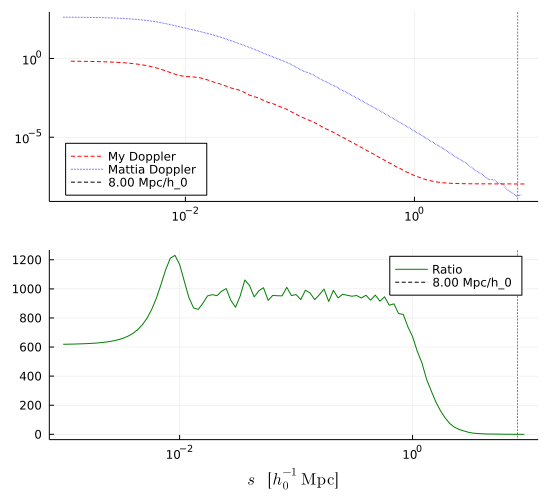

In [8]:
my_xs = my_ks
my_ys = my_pks 
xs = mattia_ks
ys = mattia_pks

spline = Spline1D(xs, ys)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [my_xs[my_ys .> 0], xs[ys .> 0]], 
    [my_ys[my_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :dot], 
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    #ylim=(0.97,1.03), legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )
savefig(P, "PS_AutoDoppler_L0.pdf")
display(P)

In [9]:
function calc_quadgk(k, f, kmin, kmax; rtol=1e-2, atol=0.0)
    en = 1e12
    res1 = quadgk( x -> en * f(x) * x * (sin(k*x) - 2), 
        kmin, kmax ; rtol = rtol, atol=atol)[1]
    res2 = quadgk( x -> 2 * en * f(x) * x , 
        kmin, kmax ; rtol = rtol, atol=atol)[1]
    res = res1 + res2
    return res / en / (8 * π^2) / k
end;

function calc_twofast(f, kmin, kmax; N = 1024)
    ks, pks = xicalc(s -> f(s), 0, 0;
        N = N, kmin = kmin, kmax = kmax, r0 = 1 / kmax) ;
    return ks, pks ./ 4
end;

In [10]:
my_xi_table = readdlm("ALL_CF_L0_files/xi_auto_doppler_L0.txt", comments=true);
my_ss = convert(Vector{Float64}, my_xi_table[:,1]);
my_xis = convert(Vector{Float64}, my_xi_table[:,2]);
my_spline = Spline1D(my_ss, my_xis);

mattia_xi_table = readdlm("../MATTIA_OUTPUTS/xi_doppler_L0.txt")
mattia_ss = convert(Vector{Float64}, mattia_xi_table[2:end, 1]);
mattia_xis = convert(Vector{Float64}, mattia_xi_table[2:end, 2]);
mattia_spline = Spline1D(mattia_ss, mattia_xis);

In [11]:
my_2fast_ks, my_2fast_pks = calc_twofast(
    my_spline, 1e-1, 1e3; N = 100);
mattia_2fast_ks, mattia_2fast_pks = calc_twofast(
    mattia_spline, 1e-1, 1e3; N = 100);

In [12]:
my_quadgk_ks = mattia_ks
mattia_quadgk_ks = mattia_ks
my_quadgk_pks = @showprogress [calc_quadgk(k, my_spline, 1e-8, 1e2; rtol=1e-8, atol=0.0) 
    for k in my_quadgk_ks];
mattia_quadgk_pks = @showprogress [calc_quadgk(k, mattia_spline, 1e-8, 1e2; rtol=1e-8, atol=0.0) 
    for k in mattia_ks];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [13]:
my_xs = my_ss
my_ys = my_xis 
xs = mattia_ss
ys = mattia_pks

spline = Spline1D(xs, ys)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [my_xs[my_ys .> 0], xs[ys .> 0]], 
    [my_ys[my_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :dot], 
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    #ylim=(0.97,1.03), legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )
savefig(P, "PS_AutoDoppler_L0.pdf")
display(P)

LoadError: length of x and y must match

In [14]:
orig_table = readdlm("../test/datatest/I04_tilde_extended.txt", comments=true);
orig_ss = convert(Vector{Float64}, orig_table[:,1]);
orig_I04_tildes = convert(Vector{Float64}, orig_table[:,2]);

In [16]:
calc_I04_tildes = [
-1.700483708601446e17 , -1.6089409716090813e17 , -1.5223262869430435e17 , -1.4403743610308603e17 , -1.3628341819421485e17 , 
-1.2894682505599886e17 , -1.2200518531408685e17 , -1.1543723730351885e17 , -1.0922286394601603e17 , -1.0334303113304176e17 , 
-9.777972942591378e16 , -9.251591889438992e16 , -8.75354769247803e16 , -8.28231488377231e16 , -7.836450116436974e16 , 
-7.414587743787272e16 , -7.0154356364762504e16 , -6.6377712248101176e16 , -6.2804377541190136e16 , -5.9423407417135976e16 , 
-5.622444624575791e16 , -5.3197695875153176e16 , -5.0333885620773176e16 , -4.762424387008815e16 , -4.50604712158679e16 , 
-4.263471503578739e16 , -4.033954544049887e16 , -3.816793251649842e16 , -3.6113224794085864e16 , -3.416912887446672e16 , 
-3.232969015359473e16 , -3.0589274583715944e16 , -2.894255141674874e16 , -2.7384476876645984e16 , -2.591027871072891e16 , 
-2.4515441572673724e16 , -2.3195693192382164e16 , -2.194699129037323e16 , -2.076551119661761e16 , -1.9647634135891612e16 , 
-1.858993614376949e16 , -1.7589177579305754e16 , -1.6642293202284206e16 , -1.5746382784642218e16 , -1.4898702227313606e16 , 
-1.4096655155281246e16 , -1.3337784965096774e16 , -1.2619767300508414e16 , -1.1940402933151194e16 , -1.1297611026493516e16 , 
-1.0689422762407814e16 , -1.01139753108447e16 , -9.569506124139352e15 , -9.054347538474696e15 , -8.566921665965936e15 , 
-8.105735561721101e15 , -7.669376651075282e15 , -7.256508402991808e15 , -6.865866236378937e15 , -6.496253646783196e15 , 
-6.14653854159571e15 , -5.815649772546876e15 , -5.502573854868243e15 , -5.20635186307301e15 , -4.926076493847051e15 , 
-4.660889287054369e15 , -4.4099779963450575e15 , -4.1725741013124185e15 , -3.9479504535788315e15 , -3.73541904960079e15 , 
-3.5343289233713035e15 , -3.3440641525651305e15 , -3.164041972020023e15 , -2.993710988775468e15 , -2.8325494932019425e15 , 
-2.6800638610477355e15 , -2.535787041508892e15 , -2.3992771266915305e15 , -2.2701159980846835e15 , -2.1479080458981032e15 , 
-2.0322789573423928e15 , -1.922874570140048e15 , -1.8193597877559185e15 , -1.7214175530243658e15 , -1.628747877029556e15 , 
-1.5410669202643748e15 , -1.4581061232536112e15 , -1.3796113839786668e15 , -1.3053422795841882e15 , -1.2350713299828732e15 , 
-1.168583301102896e15 , -1.1056745456438315e15 , -1.0461523793219501e15 , -9.89834490694267e14 , -9.36548382753768e14 , 
-8.861308445854326e14 , -8.384274514647645e14 , -7.932920918677346e14 , -7.505865199433222e14 , -7.10179932077981e14 , 
-6.719485662550564e14 , -6.357753229820155e14 , -6.015494066244602e14 , -5.691659860483081e14 , -5.385258735307515e14 , 
-5.095352209565178e14 , -4.821052323689014e14 , -4.5615189199512844e14 , -4.3159570691304806e14 , -4.083614635709174e14 , 
-3.863779974145526e14 , -3.655779749162223e14 , -3.4589768733764794e14 , -3.272768555954494e14 , -3.096584456313206e14 , 
-2.929884937214571e14 , -2.772159411901605e14 , -2.6229247802135844e14 , -2.4817239488905222e14 , -2.3481244315344972e14 , 
-2.2217170239398103e14 , -2.1021145507345616e14 , -1.988950679494665e14 , -1.881878798698164e14 , -1.7805709560829494e14 , 
-1.6847168541562675e14 , -1.5940228997793334e14 , -1.5082113049159412e14 , -1.4270192357908675e14 , -1.3501980078518553e14 , 
-1.2775123240695317e14 , -1.2087395542421895e14 , -1.1436690530979795e14 , -1.082101515106004e14 , -1.0238483640200358e14 , 
-9.687311752851706e13 , -9.165811295382681e13 , -8.672384955282695e13 , -8.205521408726925e13 , -7.763790691517002e13 , 
-7.345839819219711e13 , -6.950388643088256e13 , -6.576225929073059e13 , -6.222205647912812e13 , -5.8872434649420914e13 , 
-5.570313418864523e13 , -5.2704447793186984e13 , -4.9867190736118664e13 , -4.718267273514408e13 , -4.464267133498811e13 , 
-4.223940672269935e13 , -3.996551789873072e13 , -3.781404013081029e13 , -3.577838362154538e13 , -3.385231332442224e13 , 
-3.2029929846376805e13 , -3.0305651378444727e13 , -2.8674196599145055e13 , -2.7130568498231504e13 , -2.5670039071266535e13 , 
-2.428813483813669e13 , -2.298062314115533e13 , -2.1743499180784395e13 , -2.0572973749266277e13 , -1.946546162459628e13 , 
-1.841757058928556e13 , -1.7426091040281287e13 , -1.648798615821962e13 , -1.5600382605900377e13 , -1.4760561727494703e13 , 
-1.396595122152819e13 , -1.3214117262135527e13 , -1.2502757044454451e13 , -1.1829691731325842e13 , -1.1192859779697117e13 , 
-1.059031062628716e13 , -1.0020198713173342e13 , -9.480777835001215e12 , -8.970395790502621e12 , -8.48748932194094e12 , 
-8.030579326982533e12 , -7.598266328329406e12 , -7.18922618723672e12 , -6.80220604778587e12 , -6.436020499491225e12 , 
-6.08954794648632e12 , -5.761727172169073e12 , -5.451554088783646e12 , -5.158078661983109e12 , -4.880402000953411e12 , 
-4.617673605185522e12 , -4.3690887594631606e12 , -4.133886069087033e12 , -3.9113451277862544e12 , -3.700784311173795e12 , 
-3.501558688987812e12 , -3.3130580497238423e12 , -3.134705031607754e12 , -2.9659533541846885e12 , -2.806286145107423e12 , 
-2.6552143569994575e12 , -2.512275269543536e12 , -2.377031072207831e12 , -2.249067523268719e12 , -2.1279926810228108e12 , 
-2.0134357033021824e12 , -1.9050457116156304e12 , -1.802490716437058e12 , -1.705456600349188e12 , -1.6136461559280183e12 , 
-1.5267781754212554e12 , -1.4445865894323372e12 , -1.3668196519720176e12 , -1.2932391693813508e12 , -1.2236197707643147e12 , 
-1.1577482176955352e12 , -1.0954227510887148e12 , -1.0364524732253419e12 , -9.806567630508645e11 , -9.278647229474156e11 , 
-8.779146552886515e11 , -8.306535671733597e11 , -7.859367018209364e11 , -7.436270951934153e11 , -7.035951564860027e11 , 
-6.657182712012433e11 , -6.298804255910033e11 , -5.959718513160171e11 , -5.638886892345992e11 , -5.335326712907244e11 , 
-5.0481081952716406e11 , -4.776351613017278e11 , -4.519224598343845e11 , -4.275939592599296e11 , -4.045751434053245e11 , 
-3.8279550755285187e11 , -3.6218834249004175e11 , -3.426905301848977e11 , -3.2424235046061743e11 , -3.0678729807766223e11 , 
-2.9027190966290393e11 , -2.7464559995576956e11 , -2.5986050686979175e11 , -2.4587134489502136e11 , -2.3263526639227954e11 , 
-2.201117303544001e11 , -2.0826237823250354e11 , -1.970509164469495e11 , -1.864430052231229e11 , -1.7640615341156262e11 , 
-1.6690961897027075e11 , -1.5792431480440042e11 , -1.494227196749013e11 , -1.4137879390325534e11 , -1.337678996141082e11 , 
-1.265667252715051e11 , -1.1975321427759892e11 , -1.133064974151242e11 , -1.0720682892672131e11 , -1.0143552603532518e11 , 
-9.597491172037189e10 , -9.080826057455806e10 , -8.591974757530814e10 , -8.129439961404742e10 , -7.691804963481654e10 , 
-7.277729324175664e10 , -6.885944764256204e10 , -6.515251280214129e10 , -6.164513468750865e10 , -5.832657049132575e10 , 
-5.518665572757574e10 , -5.221577309858979e10 , -4.94048230380635e10 , -4.674519583984272e10 , -4.422874528710989e10 , 
-4.184776370119995e10 , -3.959495833362119e10 , -3.746342902897447e10 , -3.544664709035061e10 , -3.353843528247515e10 , 
-3.1732948911350845e10 , -3.0024657922445644e10 , -2.84083299625967e10 , -2.6879014353747303e10 , -2.543202692943215e10 , 
-2.406293568756526e10 , -2.2767547215585934e10 , -2.154189384638561e10 , -2.038222150567323e10 , -1.928497821355812e10 , 
-1.8246803205131226e10 , -1.72645166367215e10 , -1.6335109846299776e10 , -1.5455736138197006e10 , -1.4623702063912344e10 , 
-1.383645917230456e10 , -1.3091596203898005e10 , -1.2386831705395794e10 , -1.172000704177798e10 , -1.108907978458213e10 , 
-1.0492117456114922e10 , -9.9272916104336e9 , -9.39287223296844e9 , -8.887222441631897e9 , -8.408793473184997e9 , 
-7.956119939504441e9 , -7.52781533922058e9 , -7.122567810979268e9 , -6.739136115319563e9 , -6.376345832860563e9 , 
-6.03308576715259e9 , -5.708304541174806e9 , -5.40100737705504e9 , -5.110253049147832e9 , -4.835151001138615e9 , 
-4.574858618343819e9 , -4.328578646852233e9 , -4.0955567516025267e9 , -3.875079205917834e9 , -3.66647070542025e9 , 
-3.469092299629735e9 , -3.2823394349119644e9 , -3.1056401027807937e9 , -2.9384530878839436e9 , -2.7802663103053484e9 , 
-2.630595257106998e9 , -2.488981498306131e9 , -2.3549912827422943e9 , -2.2282142095336995e9 , -2.1082619710534186e9 , 
-1.9947671635754478e9 , -1.8873821619476686e9 , -1.7857780548448992e9 , -1.6896436373409216e9 , -1.5986844577136538e9 , 
-1.512621915564032e9 , -1.4311924084861617e9 , -1.3541465246750987e9 , -1.2812482789992204e9 , -1.2122743901974223e9 , 
-1.1470135969871843e9 , -1.085266010988833e9 , -1.0268425044840816e9 , -9.715641311335502e8 , -9.192615778790283e8 , 
-8.697746463516613e8 , -8.22951762197669e8 , -7.786495108187226e8 , -7.36732198104958e8 , -6.970714348152018e8 , 
-6.595457433314195e8 , -6.240401855828669e8 , -5.904460110003524e8 , -5.586603234222878e8 , -5.285857659323036e8 , 
-5.001302226631222e8 , -4.732065366533119e8 , -4.477322428927742e8 , -4.236293157392748e8 , -4.0082392993239146e8 , 
-3.792462344728901e8 , -3.5883013867491895e8 , -3.3951310973574275e8 , -3.2123598120296824e8 , -3.039427717526213e8 , 
-2.87580513723014e8 , -2.720990908792011e8 , -2.5745108491112146e8 , -2.4359163019526297e8 , -2.3047827637498683e8 , 
-2.180708583386203e8 , -2.0633137319706076e8 , -1.9522386388408628e8 , -1.8471430902285707e8 , -1.7477051872126538e8 , 
-1.6536203597697714e8 , -1.5646004339016685e8 , -1.4803727489821836e8 , -1.4006793226204628e8 , -1.3252760604823363e8 , 
-1.2539320086497025e8 , -1.186428646227883e8 , -1.1225592160342994e8 , -1.0621280913184413e8 , -1.0049501765733877e8 , 
-9.508503406036863e7 , -8.996628801130658e7 , -8.512310121690217e7 , -8.0540639398975e7 , -7.620486685825436e7 , 
-7.210250348419961e7 , -6.822098407912786e7 , -6.4548419872057535e7 , -6.107356210439314e7 , -5.778576757591321e7 , 
-5.467496604553316e7 , -5.1731629386995606e7 , -4.894674240501151e7 , -4.6311775222467825e7 , -4.381865715412333e7 , 
-4.145975198677094e7 , -3.922783459015269e7 , -3.7116068786986165e7 , -3.511798641432291e7 , -3.3227467512103215e7 , 
-3.1438721578227464e7 , -2.9746269832730394e7 , -2.8144928436733715e7 , -2.662979261477878e7 , -2.5196221631907824e7 , 
-2.3839824579478517e7 , -2.2556446926176455e7 , -2.1342157793031294e7 , -2.019323791346136e7 , -1.9106168241469916e7 , 
-1.80776191730997e7 , -1.710444034813334e7 , -1.6183651000801995e7 , -1.5312430829947744e7 , -1.4488111360675974e7 , 
-1.3708167771038624e7 , -1.2970211158714786e7 , -1.2271981224001605e7 , -1.1611339346704261e7 , -1.098626203572043e7 , 
-1.0394834731255218e7 , -9.835245940683972e6 , -9.305781690101e6 , -8.804820274560068e6 , -8.330827290927195e6 , 
-7.882350938131463e6 , -7.458017570419086e6 , -7.056527489990859e6 , -6.676650966135832e6 , -6.317224468668551e6 , 
-5.977147104132875e6 , -5.655377243856871e6 , -5.350929333530955e6 , -5.062870874536945e6 , -4.790319567782459e6 , 
-4.532440611292174e6 , -4.288444143278802e6 , -4.057582822862229e6 , -3.839149541026495e6 , -3.632475254803789e6 , 
-3.436926938051463e6 , -3.2519056425456223e6 , -3.0768446634525843e6 , -2.911207803559082e6 , -2.7544877309448556e6 , 
-2.606204425067169e6 , -2.465903706497817e6 , -2.333155845809353e6 , -2.2075542473495966e6 , -2.0887142038729647e6 , 
-1.976271718214217e6 , -1.8698823883953956e6 , -1.769220352751246e6 , -1.6739772918420397e6 , -1.5838614840967734e6 , 
-1.4985969122942896e6 , -1.4179224181454724e6 , -1.341590902387158e6 , -1.269368567937639e6 , -1.201034203795651e6 , 
-1.1363785074894985e6 , -1.0752034440009787e6 , -1.0173216392006156e6 , -962555.8059362835 , -910738.2010174055 , 
-861710.1114315288 , -815321.3682195683 , -771429.8865207736 , -729901.230378635 , -690608.2009747203 , 
-653430.4470292891 , -618254.0961753317 , -584971.4061769793 , -553480.43492401 , -523684.7281916362 , 
-495493.0242092483 , -468818.9741332015 , -443580.8775674881 , -419701.4323222302 , -397107.4976434961 , 
-375729.8701892629 , -355503.072065335 , -336365.1502720001 , -318257.486947151 , -301124.6198246455 , 
-284914.07235800463 , -269576.19298911485 , -255064.00306963501 , -241333.05296930936 , -228341.28593044562 , 
-216048.90925156488 , -204418.27240567078 , -193413.75171981478 , -183001.6412627523 , -173150.04960647903 , 
-163828.80214543923 , -155009.34867422175 , -146664.67594065453 , -138769.22490646166 , -131298.81246205547 , 
-124230.55735568395 , -117542.810110061 , -111215.0867118179 , -105228.00587067533 , -99563.22965616356 , 
-94203.40733006767 , -89132.12220255929 , -84333.84134924215 , -79793.8680350969 , -75498.29669960441 , 
-71433.97036517135 , -67588.44033840191 , -63949.92808078609 , -60507.289132016194 , -57249.978975432256 , 
-54168.020741044595 , -51251.97464721136 , -48492.90908737274 , -45882.37327328311 , -43412.37135095009 , 
-41075.33790999859 , -38864.11481144862 , -36771.92926293105 , -34792.373074188275 , -32919.38302932036 , 
-31147.222315659423 , -29470.462952389724 , -27883.969165093968 , -26382.881655303765 , -24962.602716872512 , 
-23618.782153584132 , -22347.303954863997 , -21144.273688781057 , -20006.006573726743 , -18929.016192235602 , 
-17910.00381237861 , -16945.848284021777 , -16033.596479002998 , -15170.454245946148 , -14353.777852007925 , 
-13581.065885344135 , -12849.951593493299 , -12158.195634210857 , -11503.679216550123 , -10884.397611181932 , 
-10298.454010075504 , -9744.053716733297 , -9219.498649184905 , -8723.182138903307 , -8253.584009712842 , 
-7809.265921616056 , -7388.866965277997 , -6991.099493674107 , -6614.74517813456 , -6258.651276704888 , 
-5921.727103393333 , -5602.94068749034 , -5301.315612728186 , -5015.928026599171 , -4745.9038106722555 , 
-4490.415903241061 , -4248.681766102634 , -4019.96098770808 , -3803.553015343567 , -3598.7950093956774 , 
-3405.0598131287957 , -3221.7540317562257 , -3048.3162149213285 , -2884.215137021789 , -2728.948170109812 , 
-2582.039744384515 , -2443.0398915612154 , -2311.5228666560065 , -2187.085843964293 , -2069.3476832391857 , 
-1957.947762290623 , -1852.5448724296155 , -1752.8161733744193 , -1658.361687329357 , -1569.104273471661 , 
-1484.6504134880468 , -1404.7415918342474 , -1329.1332257131 , -1257.5938776084158 , -1189.9045746413144 , 
-1125.8581228776918 , -1065.2584815671707 , -1007.9201552269352 , -953.6676380319826 , -902.334864915405 , 
-853.764706376001 , -807.8084914862806 , -764.3255492229927 , -723.1827786349222 , -684.2542411294258 , 
-647.4207781053353 , -612.5696383056444 , -579.5941446011425 , -548.3933551984951 , -518.8717642203391 , 
-490.939003744833 , -464.509569292306 , -439.5025581770796 , -415.8414213268253 , -393.4537289856435 , 
-372.27094969425286 , -352.22823940245945 , -333.26424412713027 , -315.3209116003238 , -298.34331348615655 , 
-282.2794777630642 , -267.08022895090454 , -252.69903815010372 , -239.0918802683686 , -226.21709962875835 , 
-214.0352822041645 , -202.5091351481329 , -191.6033724509359 , -181.28460694991352 , -171.52124831907494 , 
-162.28340622643623 , -153.54279903998423 , -145.27266706657673 , -137.4476905802635 , -130.04391252853534 , 
-123.03866512498703 , -116.41050044920647 , -110.13912487103433 , -104.20533683822718 , -98.59096808764106 , 
-93.27882812180545 , -88.2526516055379 , -83.49704852084986 , -78.99745703024165 , -74.74009897455869 , 
-70.71193768971067 , -66.90063809235625 , -63.29452889487103 , -59.88256692766416 , -56.65430331160498 , 
-53.5998514956673 , -50.70985697354414 , -47.97546865371445 , -45.38831178517457 , -42.94046231690349 , 
-40.624422622441195 , -38.433098577129996 , -36.35977784438515 , -34.398109301634754 , -32.542083631429776 , 
-30.786014915742353 , -29.124523220132065 , -27.552518151922804 , -26.0651832577351 , -24.657961290739042 , 
-23.326540271357754 , -22.06684022473443 , -20.87500082194882 , -19.747369425240905 , -18.68049001724193 , 
-17.67109252051849 , -16.716082871938255 , -15.81253352954552 , -14.957674479054521 , -14.148884802664035 , 
-13.383684596424224 , -12.659727467105467 , -11.974793263624456 , -11.326781329025502 , -10.713704052765415 , 
-10.13368079004677 , -9.584932127005512 , -9.065774387250082 , -8.574614509406059 , -8.109945181116563 , 
-7.670340210023261 , -7.254450140838959 , -6.860998148003932 , -6.48877613293066 , -6.1366410189177465 , 
-5.803511197171563 , -5.488363345154638 , -5.190229143676947 , -4.908192437451782 , -4.641386343238178 , 
-4.388990648549329 , -4.150229274670418 , -3.9243679079556624 , -3.7107117607836146 , -3.5086034306759406 , 
-3.3174208950226673 , -3.1365756090107673 , -2.96551069928048 , -2.8036992591780434 , -2.6506427428333748 , 
-2.505869428076396 , -2.368932982646671 , -2.2394110910786664 , -2.1169041651046587 , -2.0010341200084163 , 
-1.8914432160710815 , -1.787792965271619 , -1.6897630937585562 , -1.5970505620663318 , -1.5093686398665647 , 
-1.4264460189773924 , -1.348025996720218 , -1.2738656814345923 , -1.2037352507982453 , -1.137417248513281 , 
-1.0747059198016984 , -1.0154065798481047 , -0.9593350203827311 , -0.9063169433040622 , -0.8561874325989475 , 
-0.8087904412699088 , -0.7639783215570958 , -0.7216113686526018 , -0.6815574036921055 , -0.6436913500541979 , 
-0.6078948623073329 , -0.5740559750798828 , -0.5420687434242369 , -0.5118329167478561 , -0.4832536557420216 , 
-0.4562412237640007 , -0.43071070719574056 , -0.40658177522849415 , -0.38377841997112866 , -0.3622287269805526 , 
-0.3418646612181707 , -0.32262184994666177 , -0.3044393939128086 , -0.28725967680173364 , -0.2710281872824258 , 
-0.2556933579168497 , -0.24120640096545676 , -0.22752116514953485 , -0.21459398677327768 , -0.202383562969514 , 
-0.1908508194281927 , -0.1799587936243882 , -0.16967251956589904 , -0.15995892087881197 , -0.15078670889941373 , 
-0.14212628579703207 , -0.13394965482126933 , -0.12623033183889348 , -0.11894326684513287 , -0.11206476315337374 , 
-0.10557240742168397 , -0.09944499926551585 , -0.09366248617893902 , -0.08820590204265112 , -0.08305730819580553 , 
-0.07819973896725965 , -0.0736171486751662 , -0.06929436216600605 , -0.06521702865942987 , -0.06137157645948074 , 
-0.05774517161670347 , -0.054325677313486656 , -0.05110161745491335 , -0.04806213997250889 , -0.045196983591829755 , 
-0.04249644601341482 , -0.03995135409069319 , -0.037553033180292156 , -0.0352932848359166 , -0.03316435651728427 , 
-0.03115892002197746 , -0.0292700476737701 , -0.02749119151081193 , -0.02581616165886403 , -0.024239107789069795 , 
-0.022754501092227614 , -0.02135711534578788 , -0.020042012367767065 , -0.018804525485140746 , -0.017640245001409177 , 
-0.01654500455274451 , -0.015514867592450722 , -0.014546115102006268 , -0.013635233889450966 , -0.012778905204511441 , 
-0.011973994447852642 , -0.011217541028863638 , -0.010506749048896513 , -0.009838978235779993 , -0.009211735555158505 , 
-0.008622667104687037 , -0.008069550752504092 , -0.0075502887560402725 , -0.007062901085458109 , -0.006605518991852713 , 
-0.00617637894137844 , -0.005773816845031069 , -0.005396262582275403 , -0.0050422350292589685 , -0.004710336966317479 , 
-0.004399250601075133 , -0.004107733212827574 , -0.0038346129817814095 , -0.0035787850879830272 , -0.003339208068424921 , 
-0.003114900266384629 , -0.00290493657791151 , -0.002708445269494092 , -0.0025246050668561682 , -0.00235264233688308 , 
-0.0021918284319552275 , -0.002041477208480467 , -0.001900942631755594 , -0.0017696165511472367 , -0.001646926572963571 , 
-0.0015323340724217346 , -0.0014253322561177974 , -0.0013254444434341011 , -0.001232222277867212 , -0.0011452442044022197 , 
-0.0010641138725816864 , -0.0009884589546530734 , -0.0009179292818514025 , -0.0008521960590477922 , -0.0007909503733997686 , 
-0.0007339020490627861 , -0.0006807784836574977 , -0.0006313235216709919 , -0.0005852963994712863 , -0.0005424708033285846 , 
-0.0005026340744339333 , -0.000465586556210192 , -0.00043114102102092454 , -0.0003991221302935823 , -0.00036936591934016034 , 
-0.00034171918064520397 , -0.0003160388462672311 , -0.00029219140964875044 , -0.0002700522712876713 , -0.0002495051445279336 , 
-0.00023044147132082683 , -0.00021275990900362064 , -0.00019636578271129407 , -0.00018117067102348632 , -0.00016709194728753172 , 
-0.00015405240242886075 , -0.00014197987504717462 , -0.0001308069257449745 , -0.00012047052988923589 , -0.00011091178586399317 , 
-0.00010207568239061353 , -9.391079469476964e-5 , -8.636914543931193e-5 , -7.940591602020449e-5 , -7.297928445700527e-5 , 
-6.705023424581372e-5 , -6.158238583610105e-5 , -5.6541828963730944e-5 , -5.1896971873322026e-5 , -4.7618397490005195e-5 , 
-4.367872177960308e-5 , -4.0052472097565016e-5 , -3.671595844858134e-5 , -3.364716433810033e-5 , -3.082563620902789e-5 , 
-2.8232383987318704e-5 , -2.5849783330178492e-5 , -2.3661487571285533e-5 , -2.165234292084717e-5 , -1.980830750556619e-5 , 
-1.8116377708630215e-5 , -1.6564516878912317e-5 , -1.5141589111130823e-5 , -1.3837296889445003e-5 , -1.2642122540220105e-5 , 
-1.1547274163029264e-5 , -1.0544633022203343e-5 , -9.626706801672173e-6 , -8.786583203322053e-6 , -8.017888306765327e-6 , 
-7.314748103879923e-6 , -6.671750280251814e-6 , -6.083911132330373e-6 , -5.546643038900979e-6 , -5.055724898295542e-6 , 
-4.607273913543773e-6 , -4.197721255439917e-6 , -3.8237861550216675e-6 , -3.482455048386328e-6 , -3.1709604894300263e-6 , 
-2.886761845619138e-6 , -2.6275277939108067e-6 , -2.3911195317618935e-6 , -2.1755758997395787e-6 , -1.9790989496701523e-6 , 
-1.8000411093177785e-6 , -1.6368929563744273e-6 , -1.4882721324226486e-6 , -1.3529130767888774e-6 , -1.229657439923567e-6 , 
-1.1174454024332394e-6 , -1.0153075122419067e-6 , -9.223572938171822e-7 , -8.377842184902857e-7 , -7.608477351327363e-7 , 
-6.908710981877469e-7 , -6.272361614885636e-7 , -5.693784007982386e-7 , -5.167825266595063e-7 , -4.689781488675956e-7 , 
-4.2553606651450645e-7 , -3.8606473543929127e-7 , -3.502070315925891e-7 , -3.176373250104673e-7 , -2.8805874219691736e-7 , 
-2.612007669445215e-7 , -2.3681685801189844e-7 , -2.1468239870693532e-7 , -1.9459279563729467e-7 , -1.7636181117054715e-7 , 
-1.5981979677194277e-7 , -1.448123921662067e-7 , -1.311990931788214e-7 , -1.1885204038163585e-7 , -1.0765495563248591e-7 , 
-9.750204697519188e-8 , -8.829712078874301e-8 , -7.995271027826653e-8 , -7.23893063577075e-8 , -6.553465187228118e-8 , 
-5.932306693440423e-8 , -5.36948853654374e-8 , -4.8595903636453905e-8 , -4.397688944314899e-8 , -3.979312903973166e-8 , 
-3.600402822099065e-8 , -3.257272806621799e-8 , -2.946577354386906e-8 , -2.665280001381635e-8 , -2.4106253591102742e-8 , 
-2.180113357234419e-8 , -1.9714761557645707e-8 , -1.782656000287933e-8 , -1.6117874685584244e-8 , -1.4571784649269667e-8 , 
-1.3172948433536847e-8 , -1.1907457393971604e-8 , -1.076270389112042e-8 , -9.727261690094127e-9 , -8.790773978165128e-9 , 
-7.943857665509142e-9 , -7.1780101644302e-9 , -6.485529855623436e-9 , -5.859439487940749e-9 , -5.293420266168127e-9 , 
-4.7817492960026875e-9 , -4.3192445825755735e-9 , -3.901213931140878e-9 , -3.5234096113843733e-9 , -3.181986473042029e-9 , 
-2.873463909683181e-9 , -2.5946918151349162e-9 , -2.342819472568529e-9 , -2.11526728561974e-9 , -1.9097012529945002e-9 , 
-1.7240098702360273e-9 , -1.5562829377825972e-9 , -1.4047926013772885e-9 , -1.2679760716171994e-9 , -1.1444199787080204e-9 , 
-1.0328461996283298e-9 , -9.320991163194592e-10 , -8.411336797108481e-10 , -7.590053011400592e-10 , -6.848598179976103e-10 , 
-6.179254478426127e-10 , -5.575041797275882e-10 , -5.029655448510448e-10 , -4.5373960121880597e-10 , -4.093112855965542e-10 , 
-3.6921525382821264e-10 , -3.3303103889801465e-10 , -3.003787445253648e-10 , -2.7091518107432793e-10 , -2.4433035063046236e-10 , 
-2.2034423311176212e-10 , -1.98703891142425e-10 , -1.79180908511116e-10 , -1.6156898590257913e-10 , -1.4568183464426838e-10 , 
-1.3135123687709283e-10 , -1.184253031122422e-10 , -1.0676691278710804e-10 , -9.625223474642098e-11 , -8.676952512387759e-11 , 
];

In [21]:
open("I04_tilde_extended_NO_CONST.txt", "w") do io
    for (s, x) in zip(orig_ss, calc_I04_tildes)
        println(io, "$s \t $x")
    end
end

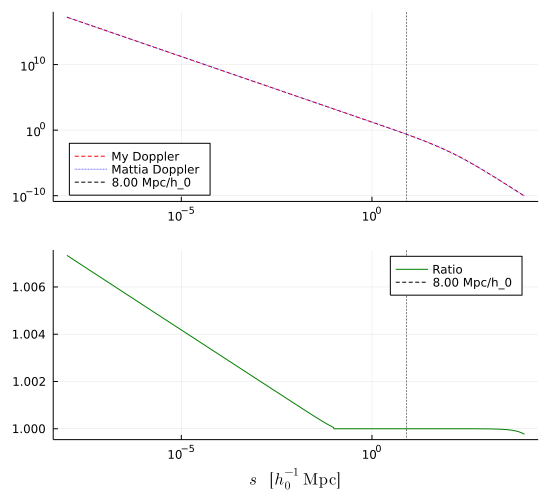

In [20]:
my_xs = orig_ss
my_ys = orig_I04_tildes 
xs = orig_ss
ys = calc_I04_tildes

spline = Spline1D(xs, ys)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [my_xs[-my_ys .> 0], xs[-ys .> 0]], 
    [-my_ys[-my_ys .> 0], -ys[-ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :dot], 
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    #ylim=(0.97,1.03), legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, 
    lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
display(P)